In [8]:
# !pip install -q monailabel-weekly
# !pip install -q monai
# !pip uninstall opencv-contrib-python -y
# !pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30
# !pip install -q timm
# !pip install -U -q openmim
# !mim install -U -q mmcv-full
# !pip install -q ml_collections
# !pip install ray

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Quantitative Evaluations

In [9]:
workspace_dir = '/content/drive/MyDrive/CardiacSeg'

import os
import sys
from pathlib import PurePath
sys.path.append(workspace_dir)

import pandas as pd

from monai.transforms import (
   Compose,
   AddChanneld,
   EnsureChannelFirstd,
   LoadImaged,
   Orientationd,
   SqueezeDimd,
   LoadImage
)
from ray import tune

from data_utils.chgh_dataset import get_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred, show_img_lbl_preds, show_img_lbl_preds_overlap

In [10]:
def get_tune_dir(root_exp_dir, exp_name):
    experiment_path = os.path.join(root_exp_dir, exp_name)

    restored_tuner = tune.Tuner.restore(experiment_path)
    result_grid = restored_tuner.get_results()

    best_result = result_grid.get_best_result(metric="tt_dice", mode="max")
    return best_result.log_dir


def get_data_path(pid, data_dir, test_idx_dict):
    idx = test_idx_dict[pid]
    data_dict = get_data_dicts(data_dir)[idx]
    return data_dict


def get_model_pred_path(root_dir, img_pth, model_name, pid):
    infer_dir = os.path.join(root_dir, 'infers', f'pid_{pid}')
    img_prefix = PurePath(img_pth).parts[-1]
    return os.path.join(infer_dir, f'{model_name}_{img_prefix}')


def get_model_eval_csv_path(root_dir, model_name):
    eval_dir = os.path.join(root_dir, 'evals')
    return os.path.join(eval_dir, f'{model_name}_best_model_eval.csv')


def get_dice_val(csv_pth, pid):
    df = pd.read_csv(csv_pth)
    idx = df['patientId'] == f'pid_{pid}'
    return df[idx]['diceC'].tolist()[0]
    

def get_slice(img, slice_idx, mode, is_trans):
    '''
    mode: a, c, s
    '''
    if mode == 'a':
        img = img[:, :, slice_idx]
    elif mode == 's':
        img = img[:, slice_idx, :]
    else:
        img = img[slice_idx, :, :]
    
    if is_trans:
        return img.T
    else:
        return img


def get_img_lbl_preds(data, exp_names, slice_idxs, mode='a', is_trans=False):
    '''
    mode: a, c, s
    '''
    preds = []
    imgs = []
    lbls = []
    for slice_idx in slice_idxs:
        pred_ls = []
        for exp_name in exp_names:
              pred_ls.append(get_slice(data[exp_name], slice_idx, mode, is_trans))
        preds.append(pred_ls)
        imgs.append(get_slice(data['image'], slice_idx, mode, is_trans))
        lbls.append(get_slice(data['label'], slice_idx, mode, is_trans))
    return imgs, lbls, preds


def get_infer_eval_dicts(root_dir, data_dir, model_names, pid):
    test_idx_dict = {'106':2, '1000':-3}
    data_dict = get_data_path(pid, data_dir, test_idx_dict)
    dice_dict = {}
    for model_name in model_names:
        key = f'{model_name}'
        data_dict[key] = get_model_pred_path(root_dir, data_dict['image'], model_name, pid)
        
        csv_pth = get_model_eval_csv_path(root_dir, model_name)
        dice_dict[key] = get_dice_val(csv_pth, pid)

    return data_dict, dice_dict

In [13]:
from pprint import pprint

workspace_dir = '/content/drive/MyDrive/CardiacSeg'
data_name = 'chgh'
sub_data_dir_name = 'dataset_2'
data_dict_file_name = 'exp_2_2.json'

data_dir = os.path.join(
    workspace_dir, 
    'dataset',
    data_name,
    sub_data_dir_name
)

root_dir = '/content/drive/MyDrive/t_1'

model_names = ['unet3d', 'attention_unet', 'cotr', 'unetr', 'swinunetr', 'unetcnx_x0']
pid = '1000'

data_dict, dice_dict = get_infer_eval_dicts(root_dir, data_dir, model_names, pid)

pprint(data_dict)
pprint(dice_dict)

{'attention_unet': '/content/drive/MyDrive/t_1/infers/pid_1000/attention_unet_pid_1000.nii.gz',
 'cotr': '/content/drive/MyDrive/t_1/infers/pid_1000/cotr_pid_1000.nii.gz',
 'image': '/content/drive/MyDrive/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz',
 'label': '/content/drive/MyDrive/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz',
 'swinunetr': '/content/drive/MyDrive/t_1/infers/pid_1000/swinunetr_pid_1000.nii.gz',
 'unet3d': '/content/drive/MyDrive/t_1/infers/pid_1000/unet3d_pid_1000.nii.gz',
 'unetcnx_x0': '/content/drive/MyDrive/t_1/infers/pid_1000/unetcnx_x0_pid_1000.nii.gz',
 'unetr': '/content/drive/MyDrive/t_1/infers/pid_1000/unetr_pid_1000.nii.gz'}
{'attention_unet': 0.8971921,
 'cotr': 0.8851475,
 'swinunetr': 0.89721036,
 'unet3d': 0.8692783,
 'unetcnx_x0': 0.9017118,
 'unetr': 0.8913427}


In [14]:
keys = list(data_dict.keys())

loader = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    Orientationd(keys=keys, axcodes='PLI'),
    SqueezeDimd(keys=keys)
])

data = loader(data_dict)

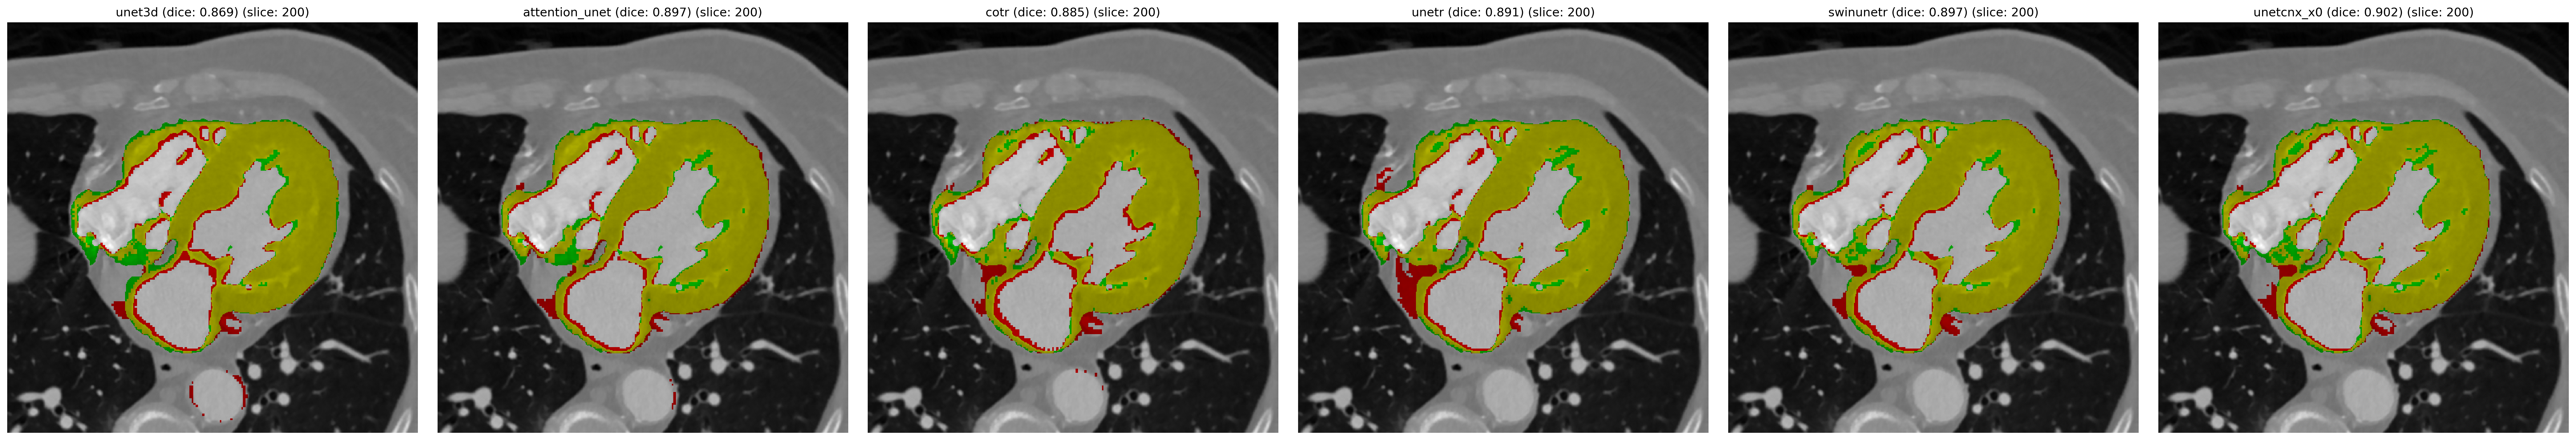

In [24]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300


num_classes = 2
slice_idxs = [200]
alpha = 0.5
axis_off = True
#num_img = len(data_dict)
#fig_size = (num_img*5, num_img*len(slice_idxs))
num_img = len(data_dict) - 2 
fig_size = (num_img*6, len(slice_idxs)*6)
show_img = False
show_lbl_dc = True

keys = dice_dict.keys()

pred_titles = [f'{key} (dice: {dice_dict[key]:.3f})'for key in keys]

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='a')

# show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

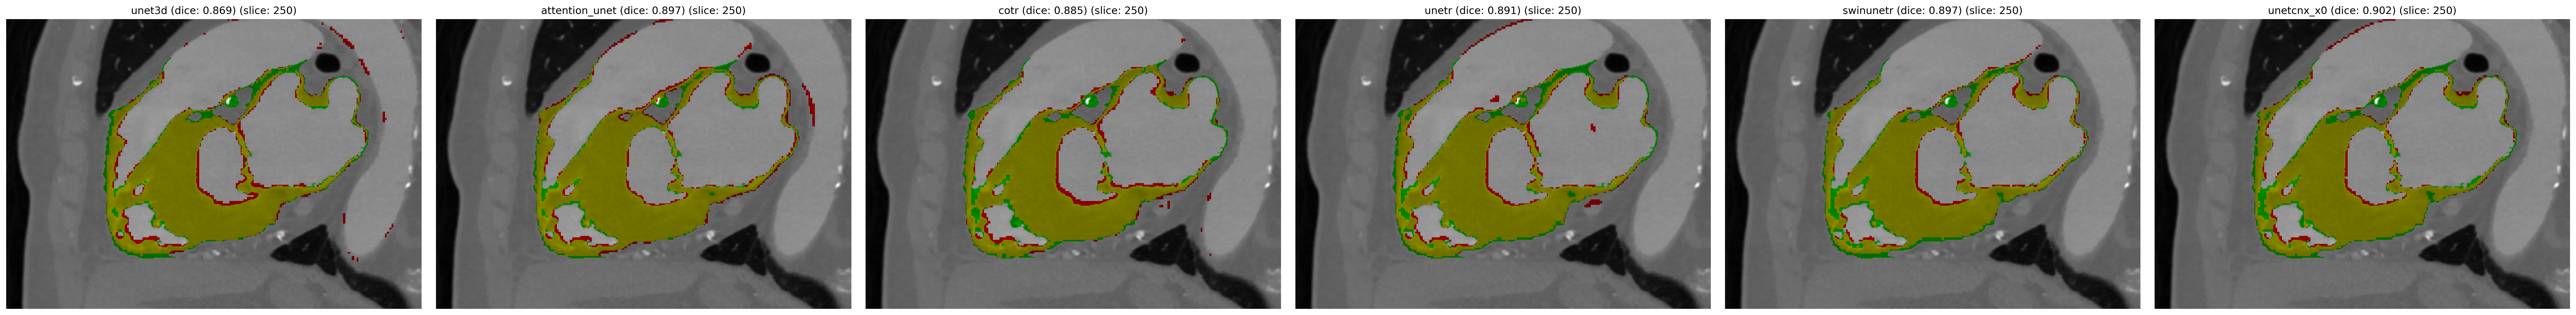

In [19]:
slice_idxs = [250] #[150,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='s', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

In [27]:
pred_titles[-1] =  'unetcnx (dice: 0.902)'

In [29]:
pred_titles

['unet3d (dice: 0.869)',
 'attention_unet (dice: 0.897)',
 'cotr (dice: 0.885)',
 'unetr (dice: 0.891)',
 'swinunetr (dice: 0.897)',
 'unetcnx (dice: 0.902)']

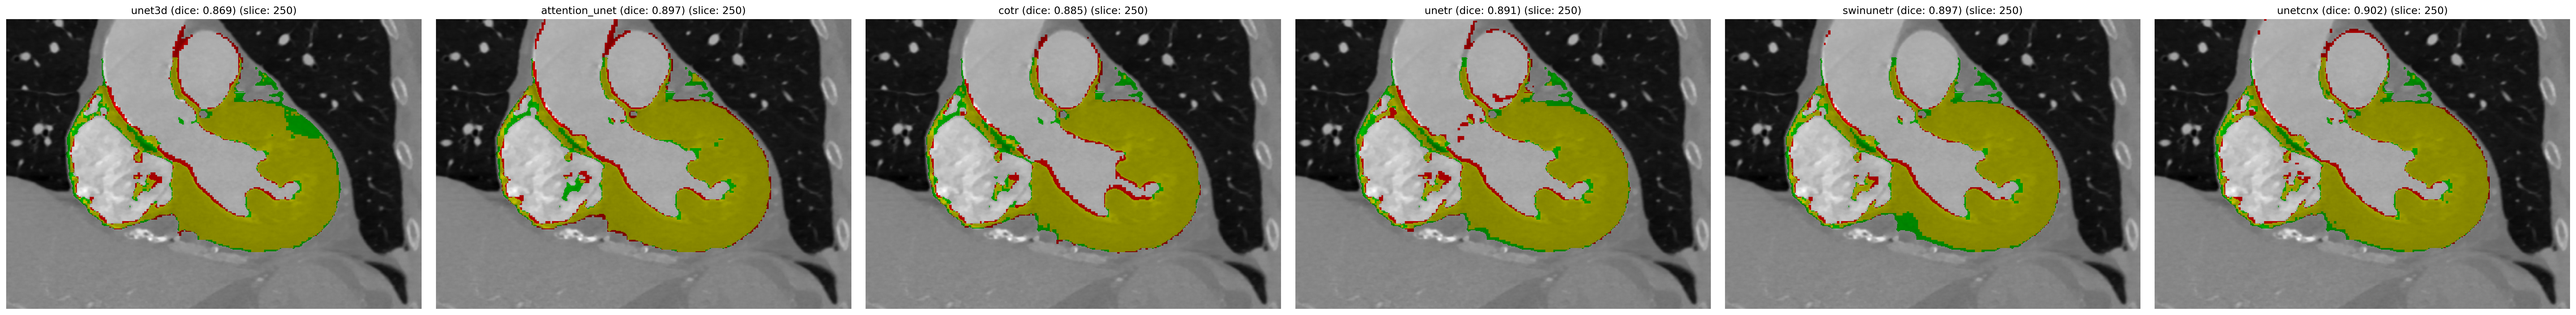

In [28]:
slice_idxs = [250] # [200,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='c', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)